In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, mean_squared_error
mse = mean_squared_error

TRAIN_FNAME = "training_data_tabular_format.csv"
TEST_FNAME = "test_data_tabular_format.csv"

from pprint import pprint
pdd = lambda x: pprint(dir(x))
pt = lambda x: print(type(x))

In [168]:
from functools import reduce
def call(f, **fkwargs):
    def g(*args, **gkwargs):
        gkwargs.update(fkwargs)
        return f(*args, **gkwargs)
    return g


dftype = pd.core.frame.DataFrame

def encode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(df)
    arr = enc.transform(df).toarray()
    return arr

DROP_COLUMNS = [
    "version", 
    "players.0.ai", 
    "players.1.ai", 
    "id", 
    "players.1.player_id", 
    "players.0.player_id",
]

In [223]:
DATA_LEN = 3000
PREP_TRAIN_STEPS = [
    call(dftype.drop, axis=1, labels=DROP_COLUMNS),
#     call(dftype.sample, n=DATA_LEN),
    call(dftype.dropna, axis="columns"),
    pd.get_dummies,
#     encode,
]

PREP_TEST_STEPS = PREP_TRAIN_STEPS

Y_COLNAME = "winner"

def split_train(df, ycolname=Y_COLNAME):
    y = df[ycolname]
    df.drop(ycolname, axis=1, inplace=True)
    x = df
    return df, y

def preprocess(df, step_fns, const_len=False):
    if not const_len:
        return reduce(lambda df, f: f(df), step_fns, df)
    else:
        for i, f in enumerate(step_fns):
            df_copy = df.copy()
            df = f(df)
            prev, cur = df_copy.shape[0], df.shape[0]
            if (prev != cur):
                print(f"Skipping function {i}, as it would change len from {prev} to {cur}")
                df = df_copy
                continue
        return df

def preprocess_train(df):
    return preprocess(df, PREP_TRAIN_STEPS)

def preprocess_test(df, train_df):
    return preprocess(df, PREP_TEST_STEPS, const_len=True)

def get_datasets(train_df, test_df):
    X_train = preprocess_train(train_df)
    X_test = preprocess_test(test_df, X_train)
    
    X_train, Y = split_train(X_train)
    
    common_columns = X_train.columns.intersection(X_test.columns)
    X_train = X_train[common_columns]
    X_test = X_test[common_columns]
    
    assert all([x == y for x, y in zip(X_train.columns, X_test.columns)])
    
#     scaler = StandardScaler().fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
#     scoring_data = scaler.transform(scoring_data)
#     pt(scoring_data)
# np.isnan(X_train).any()
    
    return X_train, Y, X_test
    

X_train, Y_train, X_test = get_datasets(pd.read_csv(TRAIN_FNAME), pd.read_csv(TEST_FNAME))

print(X_train.shape, Y_train.shape, X_test.shape)

(38658, 493) (38658,) (20000, 493)


In [195]:
XT, XV, YT, YV = train_test_split(X_train,Y_train,test_size=0.3,random_state=42)

In [224]:
model = GradientBoostingClassifier(
    random_state=42,
    verbose=1,
    
    n_estimators=500,
    learning_rate=0.1, 
    max_depth=5,
    
).fit(X_train, Y_train)
print(model)

GradientBoostingClassifier(max_depth=5, n_estimators=500, random_state=42)


In [228]:
def predict(xv, store=False, fname="UNNAMED"):
    res = model.predict_proba(xv)[:,1]
    if store:
        np.savetxt(fname, res, fmt="%.5f")
    return res

res = predict(X_test, store=True, fname="xgboost_python_n500_md5.txt")
print(res.shape)
# print(mse(res, YV))

(20000,)


In [227]:
def compare(res, fname="glmnet_full.txt"):
    snd = np.loadtxt(fname)
    err = mse(res, snd)
    return err

compare(res, fname="xgboost_full.txt")

0.03269997131904032

[1 1 2 1 2 0 1 2 1 1 2 0 1 0 0 2 2 1 1 1 0 1 0 1 2 1 1 2 0 0 0 0 2 0 0 1 2
 0 0 0 1 2 2 0 0]
Gradient Boosting Tree F1-score: 0.6666666666666666


Text(0, 0.5, 'Deviance')

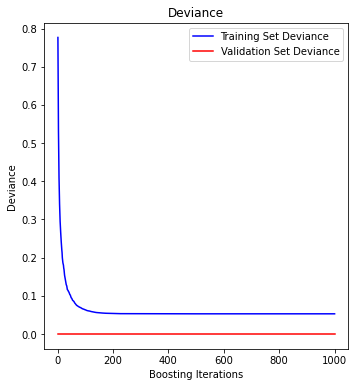

In [188]:
#split training data dan cross validation
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=0.3,random_state=42)

from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 1000,'learning_rate': 0.3, 'max_features' : 'sqrt'}

dtree=GradientBoostingClassifier(**params)
dtree.fit(X_train,Y_train)

#mau lihat F1-Score
from sklearn.metrics import f1_score

Y_pred = dtree.predict(X_val) #prediksi data cross validation menggunakan model tadi
print (Y_pred)
score = f1_score(Y_val, Y_pred, average="micro") 

print("Gradient Boosting Tree F1-score: "+str(score)) # I got 0.86 F1-Score

import matplotlib.pyplot as plt
# Plot training deviance

# compute test set deviance
val_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, Y_pred in enumerate(dtree.staged_predict(X_val)):
    val_score[i] = dtree.loss_(Y_val, Y_pred.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, dtree.train_score_, 'b-',
             label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, val_score, 'r-',
             label='Validation Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')